In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

In [3]:
home_values_dataset = pd.read_csv('homevalue.csv')
income = pd.read_csv('median_income - Sheet1.csv')
home_values_dataset.columns.values[5:] = pd.to_datetime(home_values_dataset.columns[5:])
home_values_dataset.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,...,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-30 00:00:00,2024-07-31 00:00:00,2024-08-31 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-30 00:00:00,2024-12-31 00:00:00,2025-01-31 00:00:00
0,102001,0,United States,country,NaN,119729.572640,119940.215341,120201.443305,120761.726012,121406.544234,...,350165.829700,351570.606154,352120.860853,352265.907749,352504.359843,352945.853239,353522.496915,354005.575460,354711.020713,355327.955070
1,394913,1,"New York, NY",msa,NY,214911.652349,215824.905614,216746.617250,218614.361683,220548.475724,...,647851.001125,652477.077381,655536.133683,658263.386724,661979.750511,665977.942675,669477.234967,672228.240789,673999.838327,675063.976036
2,753899,2,"Los Angeles, CA",msa,CA,218489.647448,219302.706154,220385.692595,222540.471813,224897.124751,...,911031.498845,916863.716873,920777.178084,925109.643477,930243.585193,936603.517696,941773.674116,946228.303841,950210.062120,950740.494586
3,394463,3,"Chicago, IL",msa,IL,150432.480390,150571.737044,150836.953795,151496.747161,152290.399220,...,311972.006665,314053.134292,315253.946820,315976.493240,316881.631507,317866.656523,318826.563429,319846.118364,321070.725716,322389.516129
4,394514,4,"Dallas, TX",msa,TX,125268.936932,125324.732154,125388.874474,125555.445340,125775.064467,...,372240.198836,372383.086130,371723.001722,370790.474579,370143.446717,369946.958796,369841.800601,369555.460608,369035.088390,368515.900537


In [4]:
#Cleaning Data

print("\nBefore dropping missing values:")
print("New shape for home_values:", home_values_dataset.shape)

threshold = 0.4
home_values = home_values_dataset.loc[home_values_dataset.isnull().mean(axis=1) < threshold]

#home_values_reduced.dropna(inplace=True)

print("\nAfter dropping missing values:")
print("New shape for home_values:", home_values.shape)


Before dropping missing values:
New shape for home_values: (895, 306)

After dropping missing values:
New shape for home_values: (771, 306)


In [5]:
# Interpolate across columns (i.e., across time for each region)
home_values.iloc[:, 5:] = home_values.iloc[:, 5:].interpolate(axis=1)

# Optionally fill any remaining edge NaNs with forward/backward fill
home_values.iloc[:, 5:] = home_values.iloc[:, 5:].bfill(axis=1).ffill(axis=1)

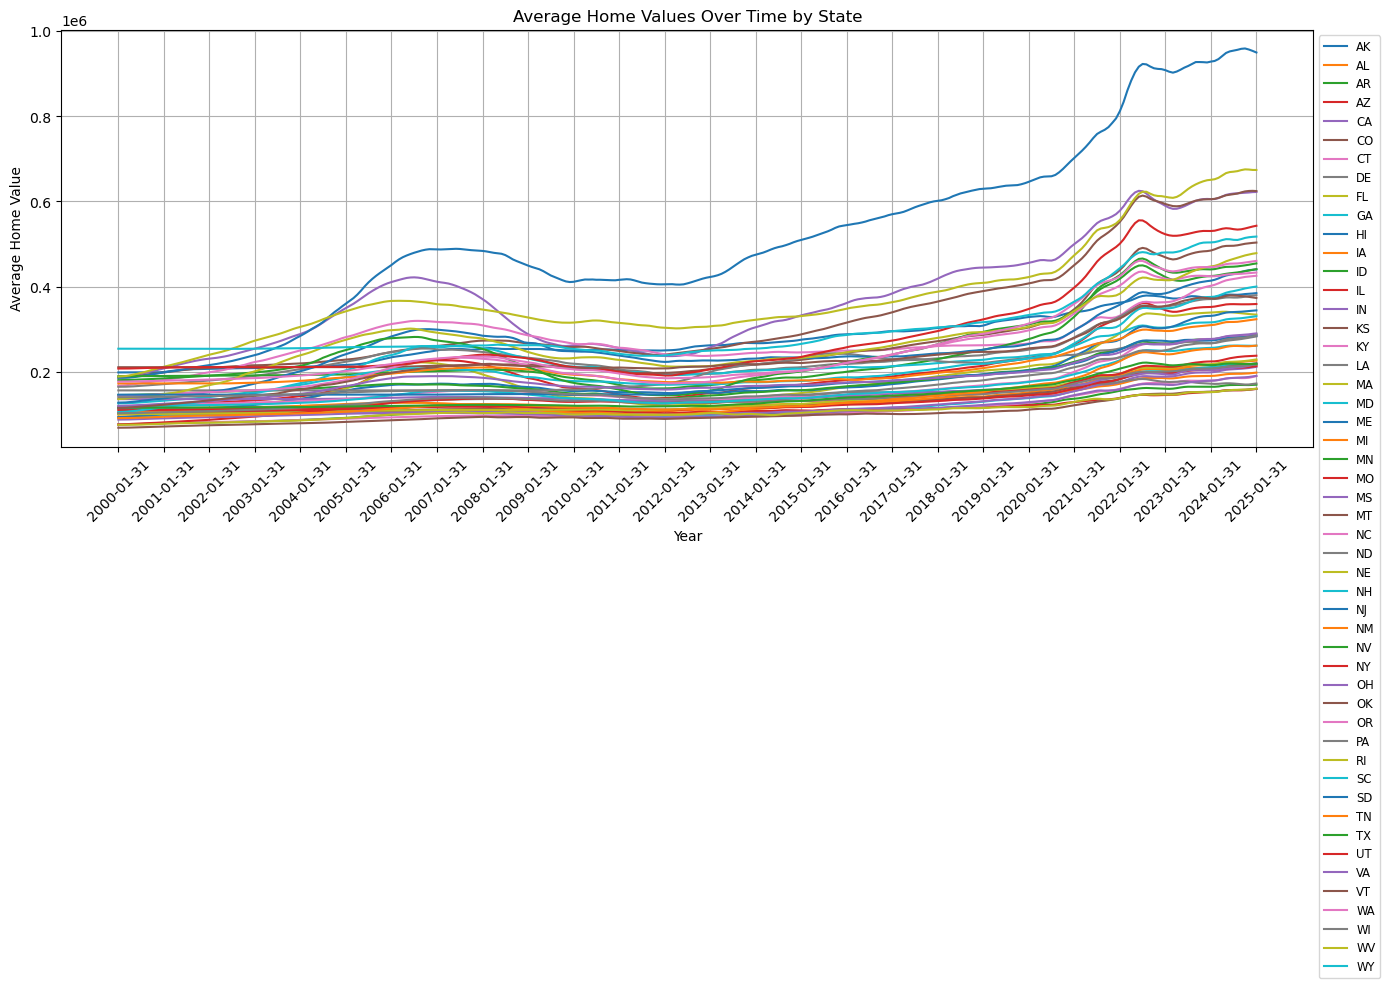

In [6]:
# Visualization: Line Plot of Average Home Values Over Time by State

import matplotlib.pyplot as plt
import numpy as np

# Let's check what we're working with
# First, get only the numeric columns (dates with home values)
numeric_cols = home_values.columns[5:]  # Assuming columns 0-4 are metadata

# Create a new DataFrame to store state averages
data_by_state = {}

# For each state, get the average values
for state, group in home_values.groupby('StateName'):
    if pd.notna(state) and state != "":  # Skip empty state names
        # For each numeric column, get the mean of values
        state_values = []
        for col in numeric_cols:
            try:
                # Convert to numeric and handle non-numeric values
                vals = pd.to_numeric(group[col], errors='coerce')
                state_values.append(vals.mean())
            except Exception as e:
                # If there's an error, just use NaN
                state_values.append(np.nan)
                print(f"Error with {state}, column {col}: {e}")
        
        # Only add states with valid data
        if any(~np.isnan(state_values)):
            data_by_state[state] = state_values

# Create a simple x-axis (0, 1, 2, ...) for plotting
x_values = np.arange(len(numeric_cols))

# Set up the plot
plt.figure(figsize=(14, 8))

# Plot each state's average home values
for state, values in data_by_state.items():
    plt.plot(x_values, values, label=state)

# Add a simplified x-axis with reasonable date labels
# Show every 12th month (approximately yearly)
step = 12  # Adjust as needed
selected_indices = np.arange(0, len(numeric_cols), step)
selected_labels = [str(numeric_cols[i]).split()[0] for i in selected_indices]  # just get the date part

plt.xticks(selected_indices, selected_labels, rotation=45)

# Customize the plot
plt.title('Average Home Values Over Time by State')
plt.xlabel('Year')
plt.ylabel('Average Home Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.grid()
plt.tight_layout()

plt.show()

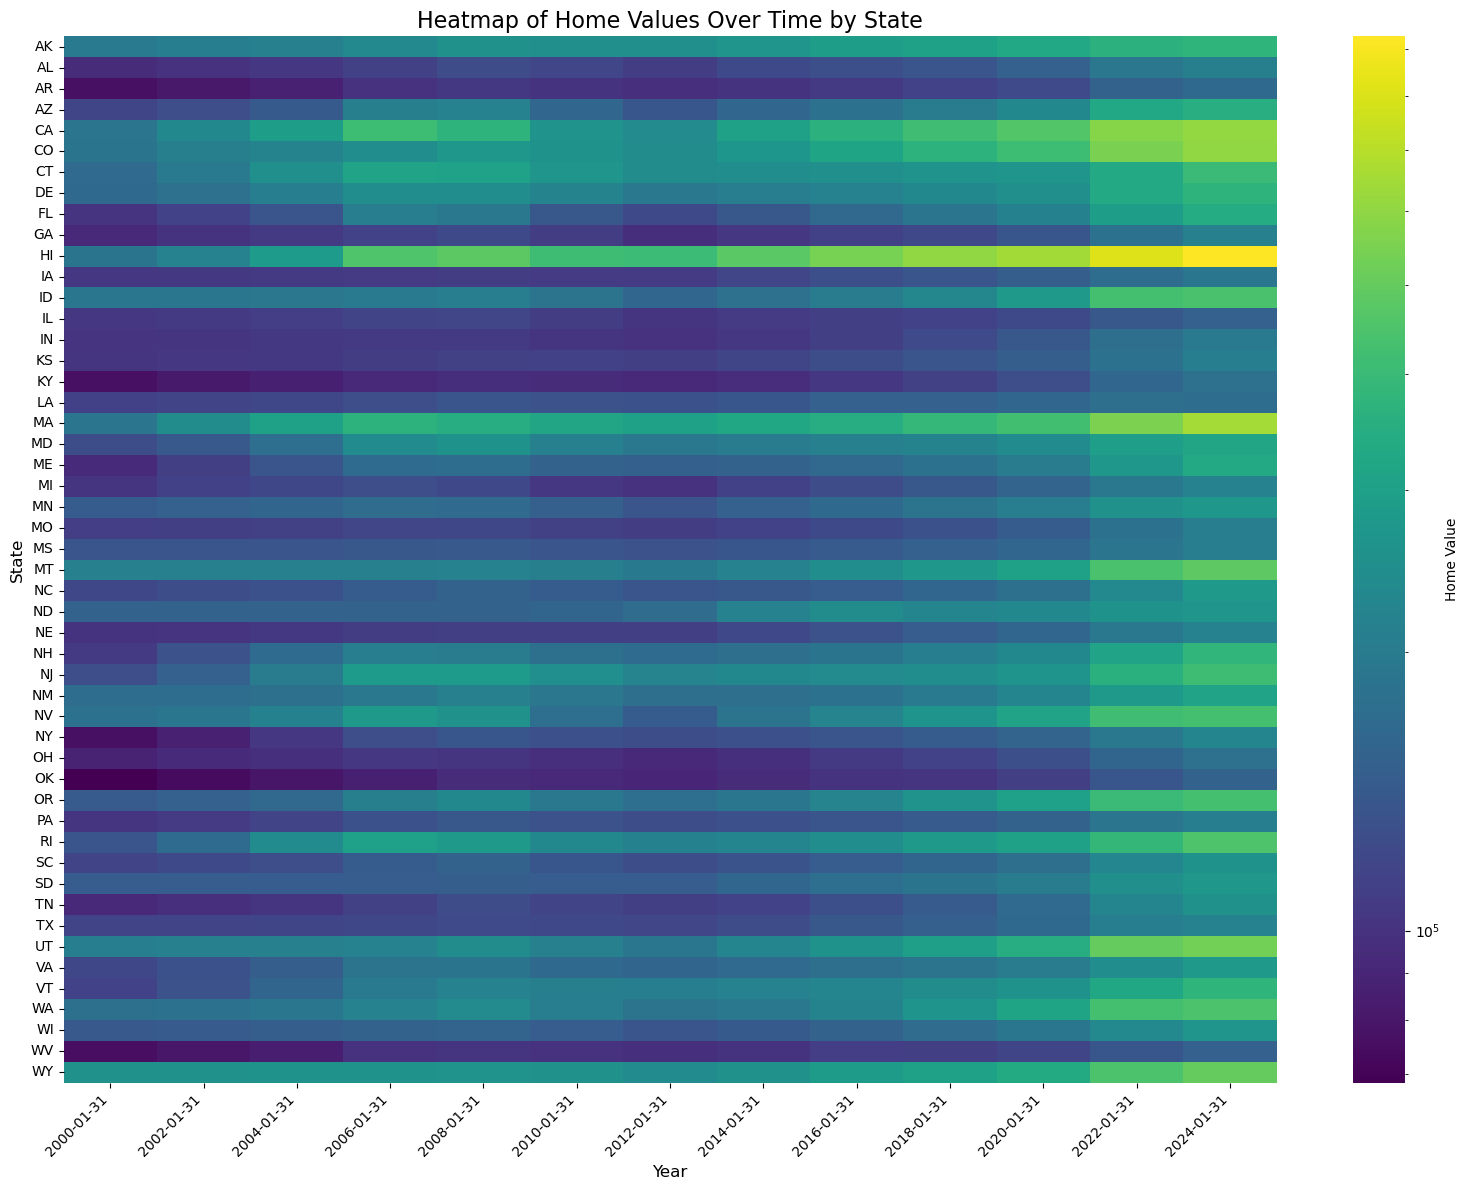

In [7]:
# Visualization: Heatmap of Home Values Over Time by State

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # Correct import for colors
import seaborn as sns
import numpy as np
import pandas as pd

# Get only the numeric columns (dates with home values)
numeric_cols = home_values.columns[5:]  # Assuming columns 0-4 are metadata

# Create a DataFrame for the heatmap
# We'll store each state's values for each time period
heatmap_data = []
state_names = []

# For each state, get the average values
for state, group in home_values.groupby('StateName'):
    if pd.notna(state) and state != "":  # Skip empty state names
        # For each numeric column, get the mean of values
        state_values = []
        for col in numeric_cols:
            try:
                # Convert to numeric and handle non-numeric values
                vals = pd.to_numeric(group[col], errors='coerce')
                state_values.append(vals.mean())
            except Exception as e:
                # If there's an error, just use NaN
                state_values.append(np.nan)
        
        # Only add states with valid data
        if any(~np.isnan(state_values)):
            heatmap_data.append(state_values)
            state_names.append(state)

# Convert to a DataFrame
heatmap_df = pd.DataFrame(heatmap_data, index=state_names)

# Optional: Select a subset of dates to make the heatmap more readable
# For example, sample every 24 months (2 years)
sample_step = 24
sampled_cols = numeric_cols[::sample_step]
sampled_data = heatmap_df.iloc[:, ::sample_step]

# Create a simplified column labels for the sampled dates
date_labels = [str(col).split()[0] for col in sampled_cols]  # Extract just the date part
sampled_data.columns = date_labels

# Set up the plot
plt.figure(figsize=(16, 12))

# Create the heatmap
# Use LogNorm from matplotlib.colors
ax = sns.heatmap(
    sampled_data, 
    cmap='viridis',  # You can choose different color maps: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
    norm=mcolors.LogNorm(),  # Correct reference to LogNorm
    cbar_kws={'label': 'Home Value'},
    xticklabels=True,
    yticklabels=True
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title('Heatmap of Home Values Over Time by State', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('State', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

Total regions found: 771
Region types found: ['country' 'msa']


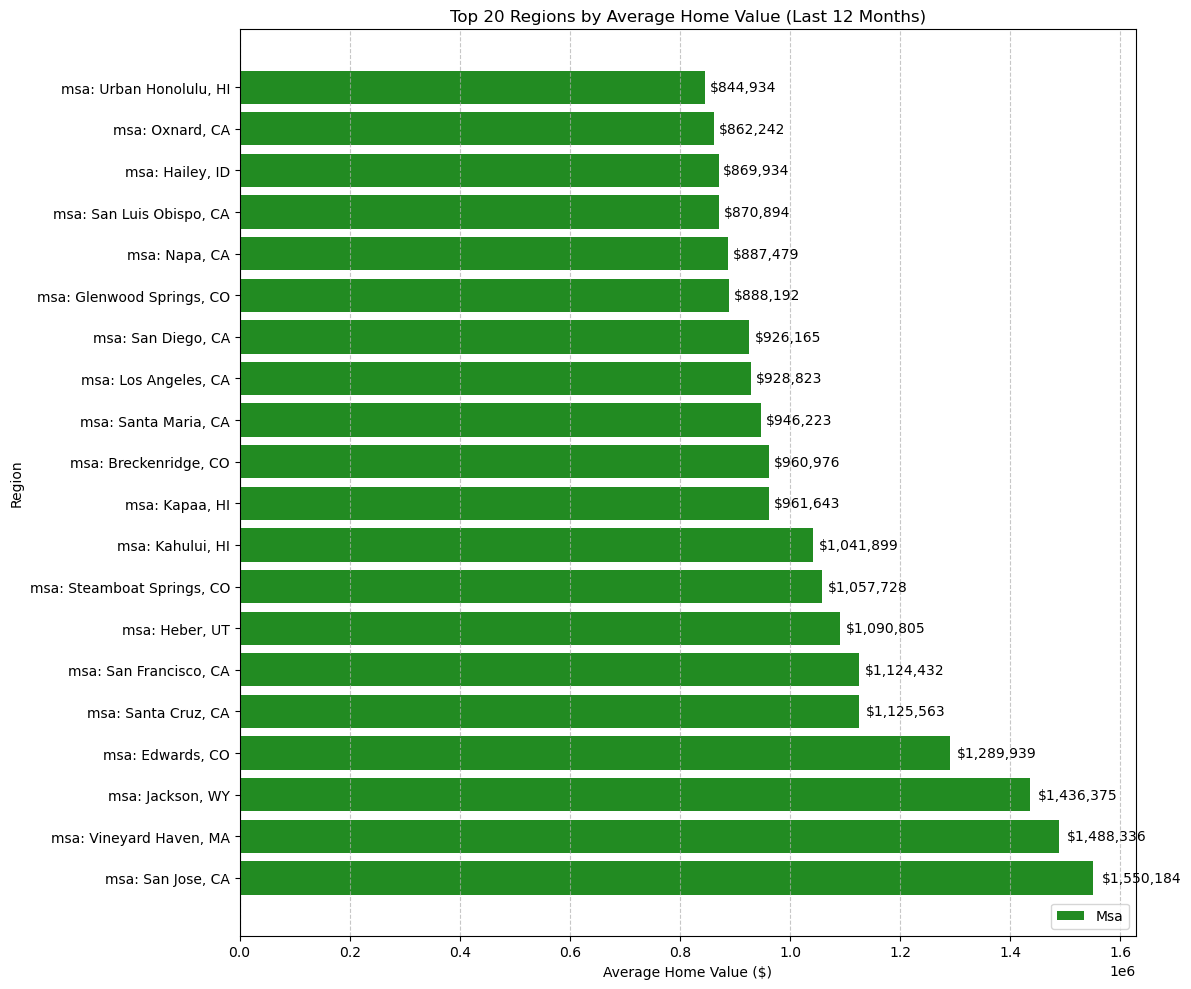


Top 20 Regions by Average Home Value:
                          Label  AverageValue
35            msa: San Jose, CA  1.550185e+06
757     msa: Vineyard Haven, MA  1.488337e+06
675            msa: Jackson, WY  1.436376e+06
516            msa: Edwards, CO  1.289940e+06
178         msa: Santa Cruz, CA  1.125563e+06
12       msa: San Francisco, CA  1.124432e+06
436              msa: Heber, UT  1.090805e+06
732  msa: Steamboat Springs, CO  1.057728e+06
254            msa: Kahului, HI  1.041900e+06
447              msa: Kapaa, HI  9.616431e+05
702       msa: Breckenridge, CO  9.609761e+05
121        msa: Santa Maria, CA  9.462232e+05
2          msa: Los Angeles, CA  9.288239e+05
17           msa: San Diego, CA  9.261658e+05
426   msa: Glenwood Springs, CO  8.881926e+05
296               msa: Napa, CA  8.874792e+05
170    msa: San Luis Obispo, CA  8.708946e+05
731             msa: Hailey, ID  8.699341e+05
70              msa: Oxnard, CA  8.622425e+05
54      msa: Urban Honolulu, HI  8.449349

In [8]:
# Visualization: Bar Chart of Average Home Values by Region - Improved Version

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

# Let's use the average of the last year's data instead of just the last column
# This might give more reliable results
last_year_cols = home_values.columns[-12:]  # Last 12 months

# Create a new DataFrame to store the average values by region
region_data = []

# Process each row in the original DataFrame directly
for idx, row in home_values.iterrows():
    region_type = row['RegionType'] if pd.notna(row['RegionType']) else "Unknown"
    region_name = row['RegionName'] if pd.notna(row['RegionName']) else "Unknown"
    
    # Skip rows with no region name
    if region_name == "Unknown":
        continue
    
    # Calculate average home value for the last year
    values = []
    for col in last_year_cols:
        try:
            val = pd.to_numeric(row[col], errors='coerce')
            if not pd.isna(val):
                values.append(val)
        except:
            pass
    
    # Only add regions with valid data
    if values:
        avg_value = np.mean(values)
        region_data.append({
            'RegionType': region_type,
            'RegionName': region_name,
            'AverageValue': avg_value
        })

# Convert to DataFrame for easier manipulation
regions_df = pd.DataFrame(region_data)

# Print some debug info
print(f"Total regions found: {len(regions_df)}")
print(f"Region types found: {regions_df['RegionType'].unique()}")

# Sort by average value (descending) and get top 20
regions_df = regions_df.sort_values('AverageValue', ascending=False).head(20)

# Create labels that include both region type and name
regions_df['Label'] = regions_df.apply(lambda x: f"{x['RegionType']}: {x['RegionName']}", axis=1)

# Set up the plot
plt.figure(figsize=(12, 10))

# Generate colors based on region types
color_map = {
    'state': 'royalblue',
    'msa': 'forestgreen',
    'county': 'tomato',
    'city': 'purple',
    'country': 'goldenrod',
    'Unknown': 'gray'
}

# Assign colors
colors = regions_df['RegionType'].map(lambda x: color_map.get(x.lower() if isinstance(x, str) else 'Unknown', 'gray'))

# Create horizontal bar chart
bars = plt.barh(regions_df['Label'], regions_df['AverageValue'], color=colors)

# Add value labels to the right of each bar
for i, (idx, row) in enumerate(regions_df.iterrows()):
    plt.text(row['AverageValue'] + row['AverageValue']*0.01, i, f"${int(row['AverageValue']):,}", va='center')

# Customize the plot
plt.title(f'Top 20 Regions by Average Home Value (Last 12 Months)')
plt.xlabel('Average Home Value ($)')
plt.ylabel('Region')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Create legend
legend_elements = [Patch(facecolor=color, label=region_type.capitalize()) 
                  for region_type, color in color_map.items()
                  if region_type in regions_df['RegionType'].str.lower().values]

plt.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()

# Display the plot
plt.show()

# Also print the data for verification
print("\nTop 20 Regions by Average Home Value:")
print(regions_df[['Label', 'AverageValue']].to_string())

Total regions found: 771
Region types found: ['country' 'msa']


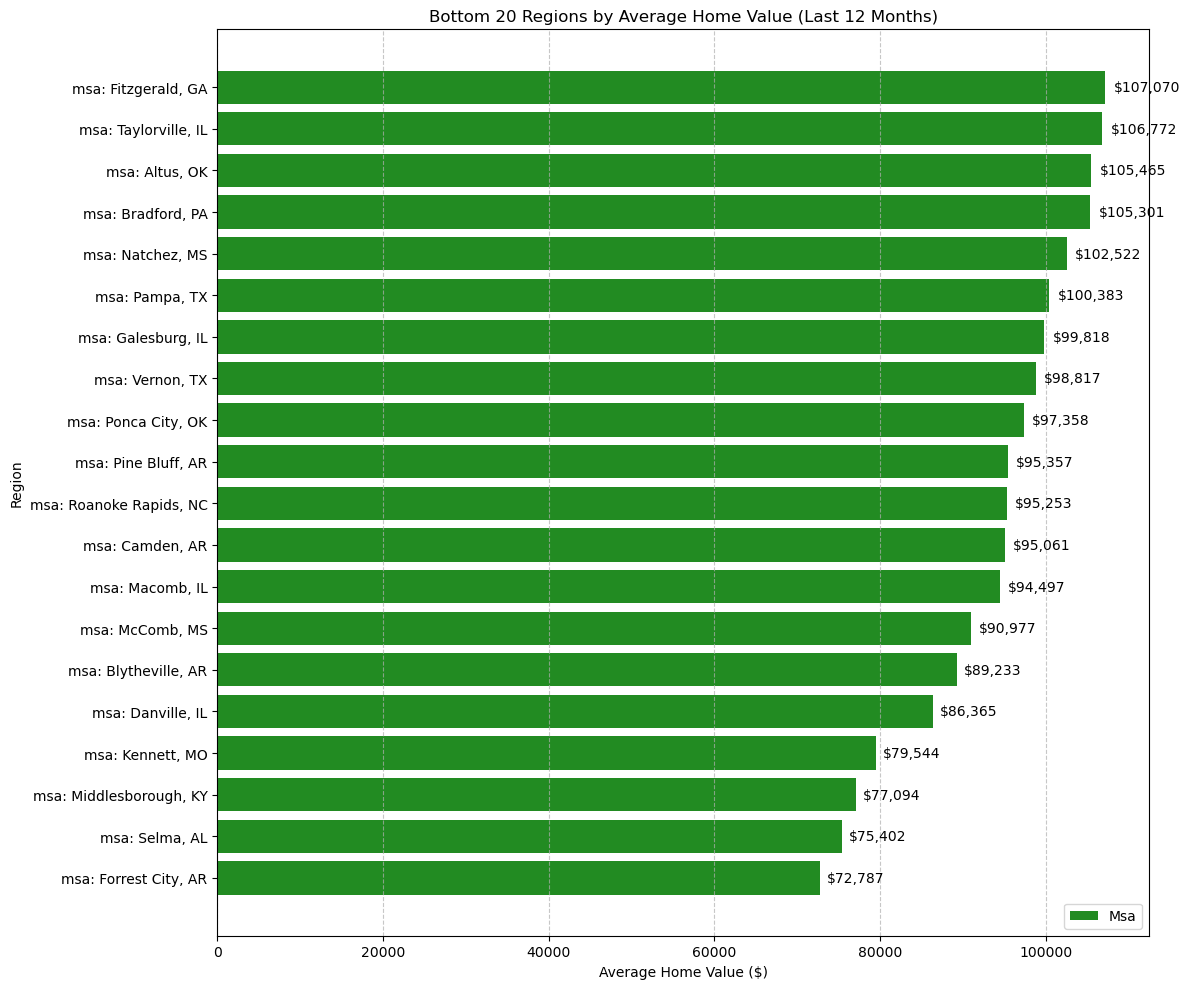


Bottom 20 Regions by Average Home Value:
                       Label   AverageValue
738    msa: Forrest City, AR   72787.762385
633           msa: Selma, AL   75402.976647
734  msa: Middlesborough, KY   77094.482770
711         msa: Kennett, MO   79544.025936
441        msa: Danville, IL   86365.541203
617     msa: Blytheville, AR   89233.184740
621          msa: McComb, MS   90977.867385
715          msa: Macomb, IL   94497.646709
716          msa: Camden, AR   95061.553730
457  msa: Roanoke Rapids, NC   95253.065375
395      msa: Pine Bluff, AR   95357.582995
596      msa: Ponca City, OK   97358.371460
770          msa: Vernon, TX   98817.586404
546       msa: Galesburg, IL   99818.731041
745           msa: Pampa, TX  100383.483809
555         msa: Natchez, MS  102522.342414
620        msa: Bradford, PA  105301.489466
729           msa: Altus, OK  105465.647739
682     msa: Taylorville, IL  106772.400514
762      msa: Fitzgerald, GA  107070.345094


In [9]:
# Visualization: Bar Chart of Lowest Average Home Values by Region

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

# Let's use the average of the last year's data 
last_year_cols = home_values.columns[-12:]  # Last 12 months

# Create a new DataFrame to store the average values by region
region_data = []

# Process each row in the original DataFrame directly
for idx, row in home_values.iterrows():
    region_type = row['RegionType'] if pd.notna(row['RegionType']) else "Unknown"
    region_name = row['RegionName'] if pd.notna(row['RegionName']) else "Unknown"
    
    # Skip rows with no region name
    if region_name == "Unknown":
        continue
    
    # Calculate average home value for the last year
    values = []
    for col in last_year_cols:
        try:
            val = pd.to_numeric(row[col], errors='coerce')
            if not pd.isna(val):
                values.append(val)
        except:
            pass
    
    # Only add regions with valid data
    if values:
        avg_value = np.mean(values)
        region_data.append({
            'RegionType': region_type,
            'RegionName': region_name,
            'AverageValue': avg_value
        })

# Convert to DataFrame for easier manipulation
regions_df = pd.DataFrame(region_data)

# Print some debug info
print(f"Total regions found: {len(regions_df)}")
print(f"Region types found: {regions_df['RegionType'].unique()}")

# Sort by average value (ascending) and get bottom 20 - HERE'S THE CHANGE
regions_df = regions_df.sort_values('AverageValue', ascending=True).head(20)

# Create labels that include both region type and name
regions_df['Label'] = regions_df.apply(lambda x: f"{x['RegionType']}: {x['RegionName']}", axis=1)

# Set up the plot
plt.figure(figsize=(12, 10))

# Generate colors based on region types
color_map = {
    'state': 'royalblue',
    'msa': 'forestgreen',
    'county': 'tomato',
    'city': 'purple',
    'country': 'goldenrod',
    'Unknown': 'gray'
}

# Assign colors
colors = regions_df['RegionType'].map(lambda x: color_map.get(x.lower() if isinstance(x, str) else 'Unknown', 'gray'))

# Create horizontal bar chart
bars = plt.barh(regions_df['Label'], regions_df['AverageValue'], color=colors)

# Add value labels to the right of each bar
for i, (idx, row) in enumerate(regions_df.iterrows()):
    plt.text(row['AverageValue'] + row['AverageValue']*0.01, i, f"${int(row['AverageValue']):,}", va='center')

# Customize the plot
plt.title(f'Bottom 20 Regions by Average Home Value (Last 12 Months)')
plt.xlabel('Average Home Value ($)')
plt.ylabel('Region')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Create legend
legend_elements = [Patch(facecolor=color, label=region_type.capitalize()) 
                  for region_type, color in color_map.items()
                  if region_type in regions_df['RegionType'].str.lower().values]

plt.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()

# Display the plot
plt.show()

# Also print the data for verification
print("\nBottom 20 Regions by Average Home Value:")
print(regions_df[['Label', 'AverageValue']].to_string())

Total regions found: 771
Region types found: ['country' 'msa']
Median home value: $237,791


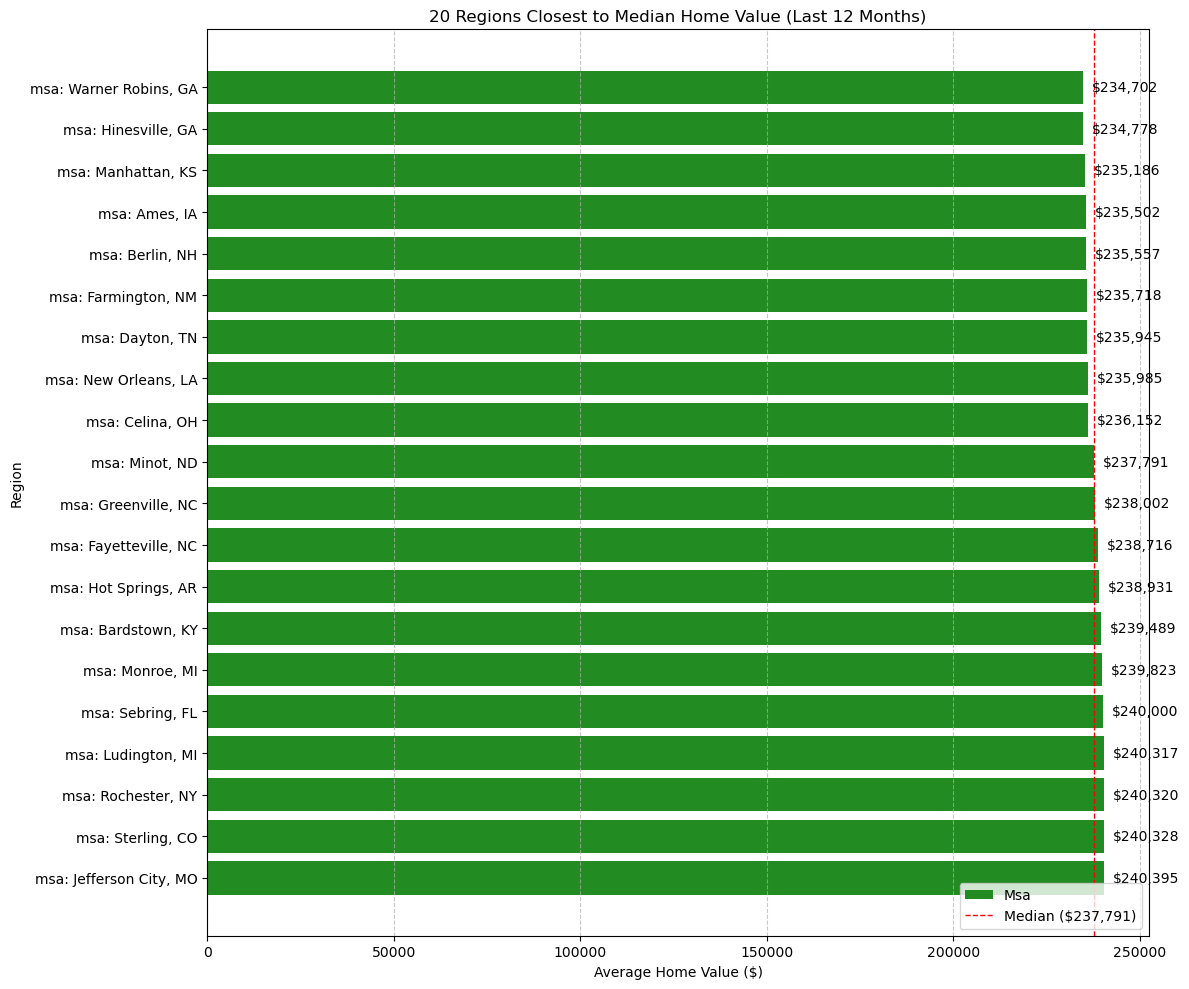


20 Regions Closest to Median Home Value:
                       Label   AverageValue  DistanceFromMedian
276  msa: Jefferson City, MO  240395.316209         2604.182674
746        msa: Sterling, CO  240328.602980         2537.469445
51        msa: Rochester, NY  240320.032461         2528.898926
706       msa: Ludington, MI  240317.649560         2526.516025
367         msa: Sebring, FL  240000.832783         2209.699248
268          msa: Monroe, MI  239823.813995         2032.680460
572       msa: Bardstown, KY  239489.124122         1697.990587
369     msa: Hot Springs, AR  238931.602009         1140.468474
106    msa: Fayetteville, NC  238716.345888          925.212353
247      msa: Greenville, NC  238002.957141          211.823606
427           msa: Minot, ND  237791.133535            0.000000
611          msa: Celina, OH  236152.691517         1638.442018
46      msa: New Orleans, LA  235985.773492         1805.360043
693          msa: Dayton, TN  235945.677390         1845.45614

In [10]:
# Visualization: Bar Chart of Middle-Range Home Values by Region

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

# Let's use the average of the last year's data 
last_year_cols = home_values.columns[-12:]  # Last 12 months

# Create a new DataFrame to store the average values by region
region_data = []

# Process each row in the original DataFrame directly
for idx, row in home_values.iterrows():
    region_type = row['RegionType'] if pd.notna(row['RegionType']) else "Unknown"
    region_name = row['RegionName'] if pd.notna(row['RegionName']) else "Unknown"
    
    # Skip rows with no region name
    if region_name == "Unknown":
        continue
    
    # Calculate average home value for the last year
    values = []
    for col in last_year_cols:
        try:
            val = pd.to_numeric(row[col], errors='coerce')
            if not pd.isna(val):
                values.append(val)
        except:
            pass
    
    # Only add regions with valid data
    if values:
        avg_value = np.mean(values)
        region_data.append({
            'RegionType': region_type,
            'RegionName': region_name,
            'AverageValue': avg_value
        })

# Convert to DataFrame for easier manipulation
regions_df = pd.DataFrame(region_data)

# Print some debug info
print(f"Total regions found: {len(regions_df)}")
print(f"Region types found: {regions_df['RegionType'].unique()}")

# Calculate the median home value
median_value = regions_df['AverageValue'].median()
print(f"Median home value: ${int(median_value):,}")

# Calculate the distance from median for each region
regions_df['DistanceFromMedian'] = abs(regions_df['AverageValue'] - median_value)

# Sort by distance from median (ascending) and get middle 20
middle_regions = regions_df.sort_values('DistanceFromMedian', ascending=True).head(20)

# Create labels that include both region type and name
middle_regions['Label'] = middle_regions.apply(lambda x: f"{x['RegionType']}: {x['RegionName']}", axis=1)

# Sort by actual value for better visualization
middle_regions = middle_regions.sort_values('AverageValue', ascending=False)

# Set up the plot
plt.figure(figsize=(12, 10))

# Generate colors based on region types
color_map = {
    'state': 'royalblue',
    'msa': 'forestgreen',
    'county': 'tomato',
    'city': 'purple',
    'country': 'goldenrod',
    'Unknown': 'gray'
}

# Assign colors
colors = middle_regions['RegionType'].map(lambda x: color_map.get(x.lower() if isinstance(x, str) else 'Unknown', 'gray'))

# Create horizontal bar chart
bars = plt.barh(middle_regions['Label'], middle_regions['AverageValue'], color=colors)

# Add a vertical line for the median
plt.axvline(x=median_value, color='red', linestyle='--', linewidth=1, label=f'Median (${int(median_value):,})')

# Add value labels to the right of each bar
for i, (idx, row) in enumerate(middle_regions.iterrows()):
    plt.text(row['AverageValue'] + row['AverageValue']*0.01, i, f"${int(row['AverageValue']):,}", va='center')

# Customize the plot
plt.title(f'20 Regions Closest to Median Home Value (Last 12 Months)')
plt.xlabel('Average Home Value ($)')
plt.ylabel('Region')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Create legend
legend_elements = [Patch(facecolor=color, label=region_type.capitalize()) 
                  for region_type, color in color_map.items()
                  if region_type in middle_regions['RegionType'].str.lower().values]
# Add median line to legend
legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label=f'Median (${int(median_value):,})'))

plt.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()

# Display the plot
plt.show()

# Also print the data for verification
print("\n20 Regions Closest to Median Home Value:")
print(middle_regions[['Label', 'AverageValue', 'DistanceFromMedian']].to_string())